In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.integrate import solve_ivp

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
d_cas = pd.read_csv("data/cascade/d_cascade_2019.csv")
d_cas = {row['State']: row for _, row in d_cas.iterrows()}

dict(d_cas['India'])

{'Region': 'India',
 'State': 'India',
 'N': 1347720000,
 'N_TB0': 3817962.400180305,
 'PrevUt': 0.0029074548816619,
 'PrevTx': 0.0019085494655813,
 'PrevTxPub': 0.0013127198765516,
 'PrevTxPri': 0.0005958295890297013,
 'Pr_Pub_CSI': 0.4828184936896596,
 'Pr_Pub_CSI0': 0.6140034463806118,
 'Pr_Pub_CSI1': 0.6060575921087298,
 'Pr_Asym': 0.6304291518439208,
 'Pr_NotAware': 0.2125506578705321,
 'Pr_NotCS': 0.0317281479252257,
 'Pr_NotDet': 0.1252920423603213,
 'Pop': 1357660000,
 'CNR_pub': 0.00127,
 'CNR_eng': 0.0005,
 'TxI_pub': 0.94,
 'TxI_eng': 0.95,
 'TxSucc_pub': 0.9032258064516128,
 'TxSucc_eng': 0.9102564102564102,
 'TxDead_pub': 0.043010752688172,
 'TxDead_eng': 0.0256410256410256,
 'TxLTFU_pub': 0.053763440860215,
 'TxLTFU_eng': 0.0641025641025641,
 'DrugTime_M': 0.0003625308641975309,
 'DrugTime_L': 0.00033567672610882484,
 'DrugTime_U': 0.0004135537265660722}

In [4]:
class Cascade:
    def __init__(self, d):
        self.Source = d
        pr_a, pr_s, pr_c, pr_e = d.Pr_Asym, d.Pr_NotAware, d.Pr_NotCS, d.Pr_NotDet
        
        self.PrevUt = d.PrevUt
        self.PrevA = self.PrevUt * pr_a
        self.PrevS = self.PrevUt * pr_s
        self.PrevC = self.PrevUt * pr_c
        self.PrevE = self.PrevUt * pr_e
        
        self.LTFU0 = np.array([d.TxLTFU_pub, d.TxLTFU_eng, d.TxLTFU_eng])
        self.Succ0 = np.array([d.TxSucc_pub, d.TxSucc_eng, d.TxSucc_eng])
        self.Die0 = np.array([d.TxDead_pub, d.TxDead_eng, d.TxDead_eng])
        
    def reform_parameters(self, **pars):
        d = self.Source
        p = dict()
        p['R_Onset'] = r_onset = pars['r_onset']
        p['R_Die_Sym'] = r_die_s = pars['r_die_ut']
        p['R_Die_Asym'] = r_die_a = pars['r_die_ut'] * pars['rr_die_asym']
        p['R_SelfCure'] = r_sc = pars['r_sc']
        
        p['IncR'] = pars['inc']
        # p['IncR'] = self.PrevA * (r_die_a + r_sc + r_onset)
        
        mu = r_die_s + r_die_a
        
        p['R_Aware'] = r_aware = r_onset * self.PrevA / self.PrevS - mu
        p['R_CSI'] = r_csi = r_aware * self.PrevS / self.PrevC - mu
        p['R_Det'] = r_csi * self.PrevC / self.PrevE - mu


        p['P_Det'] = np.array([
            pars['p_det_pub'],
            (1 - pars['p_det_pub']) * pars['p_eng'],
            (1 - pars['p_det_pub']) * (1 - pars['p_eng'])
        ])
        
        p['TxI'] = np.array([d.TxI_pub, d.TxI_eng, pars['TxI_pri']])
        p['PPV'] = np.array([pars['ppv_pub'], pars['ppv_eng'], pars['ppv_pri']])
        
        p['R_Succ'] = 1 / np.array([pars['dur_succ_pub'], pars['dur_succ_eng'], pars['dur_succ_pri']])
        p['R_Succ'][1] = p['R_Succ'][2] 
        
        p['R_LTFU'] = p['R_Succ'] * self.LTFU0 / self.Succ0
        p['R_Die_Tx'] = p['R_Succ'] * self.Die0 / self.Succ0
        
 
        p['P_OnPriDrug'] = pars['p_pridrug']
        
        return p
    
    def calc(self, p):
        inc = p['IncR']
        
        prev_a = inc / (p['R_Die_Asym'] + p['R_SelfCure'] + p['R_Onset'])
        prev = prev_a / self.PrevA * self.PrevUt
        prev_e = prev_a * self.PrevE / self.PrevA
        
        det = prev_e * p['R_Det'] * p['P_Det']
        cnr = det / p['PPV']
        txi = cnr * p['TxI']
        dur = 1 / (p['R_LTFU'] + p['R_Die_Tx'] + p['R_Succ'])

        prev_t = det * p['TxI'] * dur
        
        drug_time = txi * dur
        
        
        return {
            'IncR': inc,
            'CNR': cnr,
            'TxI': txi,
            'Duration': dur,
            'PrevUt': prev,
            'OnPriCare': drug_time[1] + drug_time[2],
            'OnPriDrug': drug_time[1] * p['P_OnPriDrug'] + drug_time[2]
        }
        

In [5]:
d = d_cas['India']

obs = np.array([d_cas['India'][k] for k in ['CNR_pub', 'CNR_eng', 'PrevUt', 'PrevTxPri', 'DrugTime_M']])
obs

eps = obs / 10
obs, eps

(array([0.00127   , 0.0005    , 0.00290745, 0.00059583, 0.00036253]),
 array([1.27000000e-04, 5.00000000e-05, 2.90745488e-04, 5.95829589e-05,
        3.62530864e-05]))

In [6]:
m = Cascade(d_cas['India'])

def simulate(rng, 
             inc,
             r_die_ut, rr_die_asym, r_sc, r_onset, ppv_pub, ppv_eng, ppv_pri, TxI_pri, 
             dur_succ_pub, dur_succ_eng, dur_succ_pri, p_det_pub, p_eng, p_pridrug, size=None):
    p = m.reform_parameters(
        inc = inc,
        r_die_ut = r_die_ut,
        rr_die_asym = rr_die_asym,
        r_sc = r_sc,
        r_onset = r_onset,

        ppv_pub = ppv_pub,
        ppv_eng = ppv_eng,
        ppv_pri = ppv_pri,

        TxI_pri = TxI_pri,
        dur_succ_pub = dur_succ_pub,
        dur_succ_eng = dur_succ_eng,
        dur_succ_pri = dur_succ_pri,

        p_det_pub = p_det_pub,
        p_eng = p_eng,
        p_pridrug = p_pridrug
    )
    ms = m.calc(p)    
    return np.array([ms['CNR'][0], ms['CNR'][1], ms['PrevUt'], ms['OnPriCare'], ms['OnPriDrug']])

In [7]:
with pm.Model() as model_lv:
    inc = pm.Uniform('inc', 0, 0.02)
    r_die_ut = pm.Uniform("r_die_ut", 0.14, 0.18)
    rr_die_asym = pm.Uniform("rr_die_asym", 0, 1)
    r_sc = pm.Uniform("r_sc", 0.1, 0.3)
    r_onset = pm.Uniform('r_onset', 0.5, 5)

    ppv_pub = 0.85 #pm.Constant('ppv_pub', 0.85)
    ppv_eng = 0.85 # pm.Constant('ppv_eng', 0.85)
    ppv_pri = pm.Uniform('ppv_pri', 0.1, 0.85)

    TxI_pri = 0.8 #pm.Uniform('TxI_pri', 0.5, 1)
    dur_succ_pub = 0.5 # pm.Constant('dur_succ_pub', 0.5)
    dur_succ_eng = pm.Uniform('dur_succ_eng', 1/ 24, 1.5)
    dur_succ_pri = pm.Uniform('dur_succ_pri', 1/ 24, 1.5)

    p_det_pub = pm.Uniform('p_det_pub', 0, 1)
    p_eng = pm.Uniform('p_eng', 0, 1)
    p_pridrug = pm.Beta('p_pridrug', 6, 1.5)
    
    sim = pm.Simulator("sim", simulate, 
                       params=(inc, 
                               r_die_ut, rr_die_asym, r_sc, r_onset, ppv_pub, ppv_eng, ppv_pri, TxI_pri, 
                               dur_succ_pub, dur_succ_eng, dur_succ_pri, p_det_pub, p_eng, p_pridrug), 
                       epsilon=eps, observed=obs)

    pprior = pm.sample_prior_predictive(samples=200)
    idata_fit = pm.sample_smc(chains=3, cores=5, draws=2000)
    ppost = pm.sample_posterior_predictive(idata_fit, var_names=["sim"])

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


(0.0, 200.0)

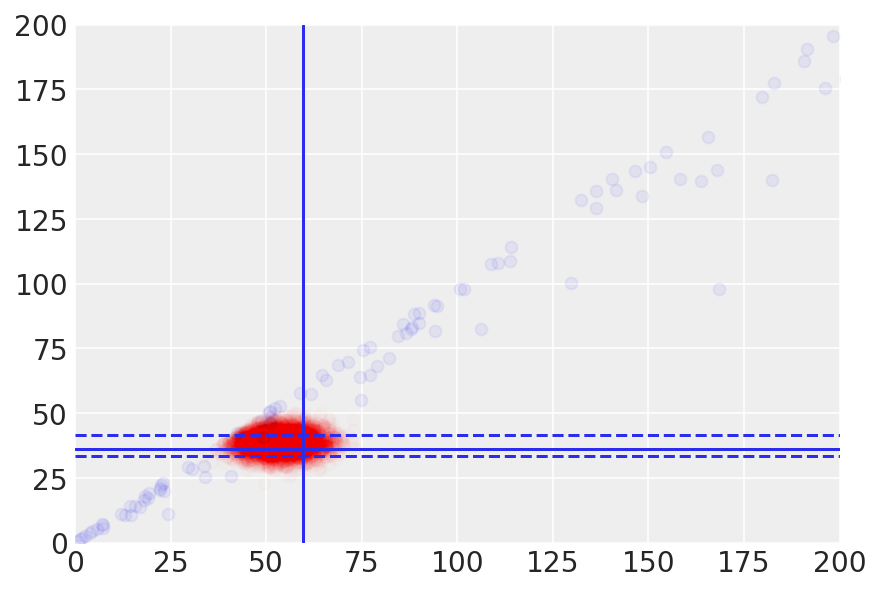

In [8]:
prior = pprior.prior_predictive.stack(samples=("draw", "chain"))['sim'] * 1e5
plt.scatter(prior[3], prior[4], color='b', alpha = 0.05)

post = ppost.posterior_predictive.stack(samples=("draw", "chain"))['sim'] * 1e5
plt.scatter(post[3], post[4], color='r', alpha = 0.01)

plt.axvline(x=d_cas['India']['PrevTxPri'] * 1e5, linestyle='-')
plt.axhline(y=d_cas['India']['DrugTime_M'] * 1e5, linestyle='-')
plt.axhline(y=d_cas['India']['DrugTime_L'] * 1e5, linestyle='--')
plt.axhline(y=d_cas['India']['DrugTime_U'] * 1e5, linestyle='--')

plt.ylim((0, 200))
plt.xlim((0, 200))

array([[<AxesSubplot:title={'center':'p_pridrug'}>,
        <AxesSubplot:title={'center':'p_pridrug'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'ppv_pri'}>,
        <AxesSubplot:title={'center':'ppv_pri'}, xlabel='Rank (all chains)'>]],
      dtype=object)

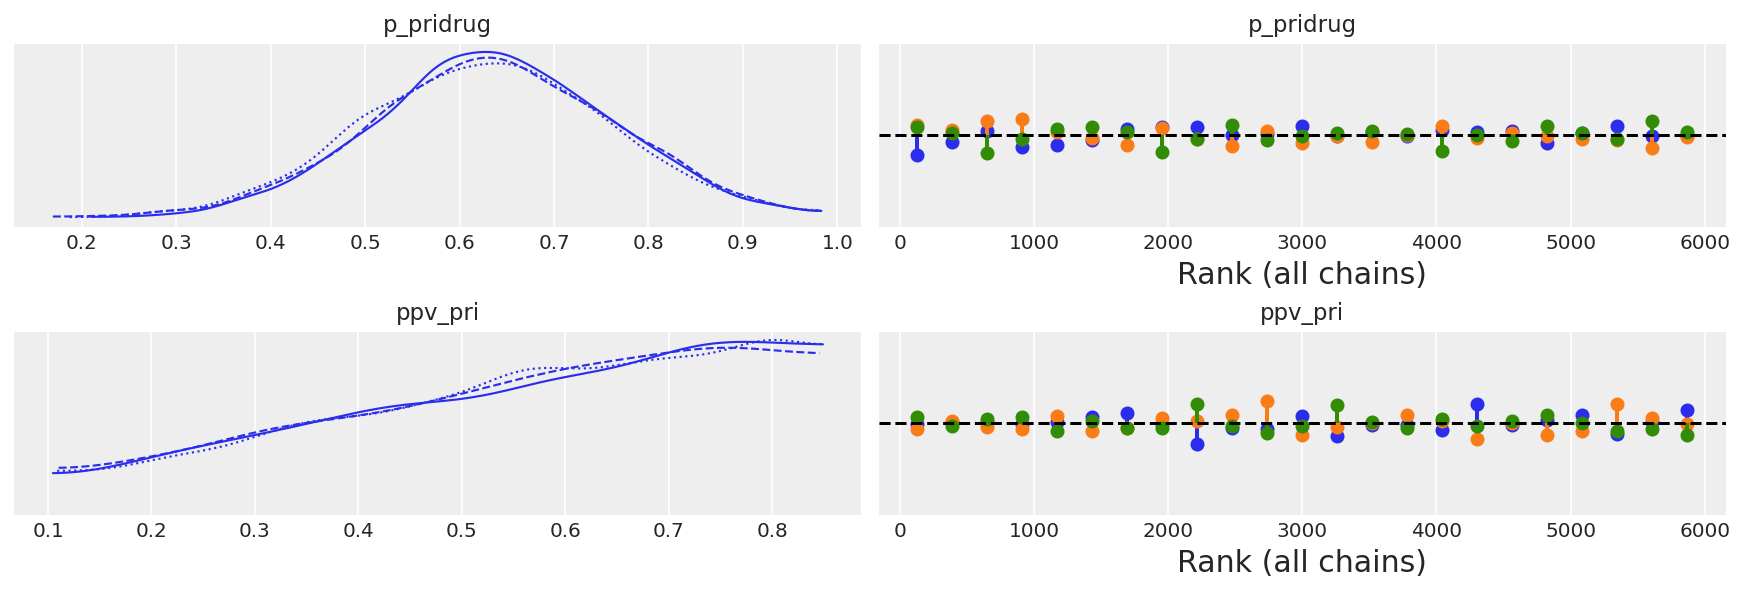

In [9]:
az.plot_trace(idata_fit, var_names=['p_pridrug', 'ppv_pri'], kind="rank_vlines")

In [10]:
m = Cascade(d_cas['India'])

with pm.Model() as model_lv:
    inc = pm.Uniform('inc', 0, 0.02)
    r_die_ut = pm.Uniform("r_die_ut", 0.14, 0.18)
    rr_die_asym = pm.Uniform("rr_die_asym", 0, 1)
    r_sc = pm.Uniform("r_sc", 0.1, 0.3)
    r_onset = pm.Uniform('r_onset', 0.5, 5)

    ppv_pub = 0.85 #pm.Constant('ppv_pub', 0.85)
    ppv_eng = 0.85 # pm.Constant('ppv_eng', 0.85)
    ppv_pri = pm.Uniform('ppv_pri', 0.1, 0.85)

    TxI_pri = 0.8 #pm.Uniform('TxI_pri', 0.5, 1)
    dur_succ_pub = 0.5 # pm.Constant('dur_succ_pub', 0.5)
    dur_succ_eng = pm.Uniform('dur_succ_eng', 1/ 24, 1.5)
    dur_succ_pri = pm.Uniform('dur_succ_pri', 1/ 24, 1.5)

    p_det_pub = pm.Uniform('p_det_pub', 0, 1)
    p_eng = pm.Uniform('p_eng', 0, 1)
    p_pridrug = pm.Beta('p_pridrug', 6, 1.5)
    
    sim = pm.Simulator("sim", simulate, 
                       params=(inc, r_die_ut, rr_die_asym, r_sc, r_onset, ppv_pub, ppv_eng, ppv_pri, TxI_pri, 
                                 dur_succ_pub, dur_succ_eng, dur_succ_pri, p_det_pub, p_eng, p_pridrug), 
                       epsilon=np.append(eps[:4], 1.0), observed=obs)

    idata_fit_reduced = pm.sample_smc(chains=3, cores=5, draws=2000)
    ppost_reduced = pm.sample_posterior_predictive(idata_fit_reduced, var_names=["sim"])

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [11]:
post_re = ppost_reduced.posterior_predictive.stack(samples=("draw", "chain"))['sim'] * 1e5
post = ppost.posterior_predictive.stack(samples=("draw", "chain"))['sim'] * 1e5

Text(0, 0.5, 'Private drug-months, per 100k')

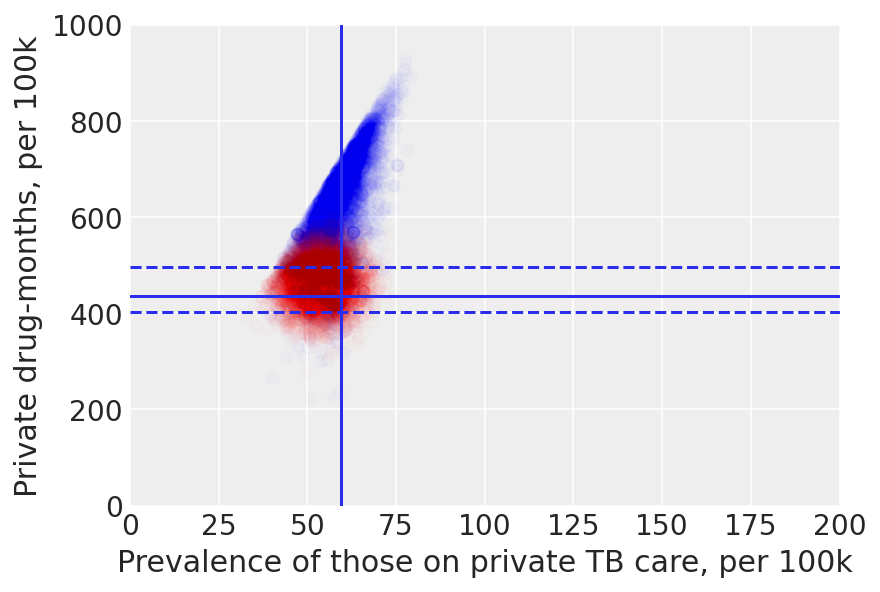

In [12]:

plt.scatter(post_re[3], post_re[4] * 12, color='b', alpha = 0.01)
plt.scatter(post[3], post[4] * 12, color='r', alpha = 0.01)

plt.axvline(x=d_cas['India']['PrevTxPri'] * 1e5, linestyle='-')
plt.axhline(y=d_cas['India']['DrugTime_M'] * 12e5, linestyle='-')
plt.axhline(y=d_cas['India']['DrugTime_L'] * 12e5, linestyle='--')
plt.axhline(y=d_cas['India']['DrugTime_U'] * 12e5, linestyle='--')

plt.ylim((0, 1000))
plt.xlim((0, 200))
plt.xlabel('Prevalence of those on private TB care, per 100k')
plt.ylabel('Private drug-months, per 100k')

Text(0, 0.5, 'CNR, engaged private, per 100k')

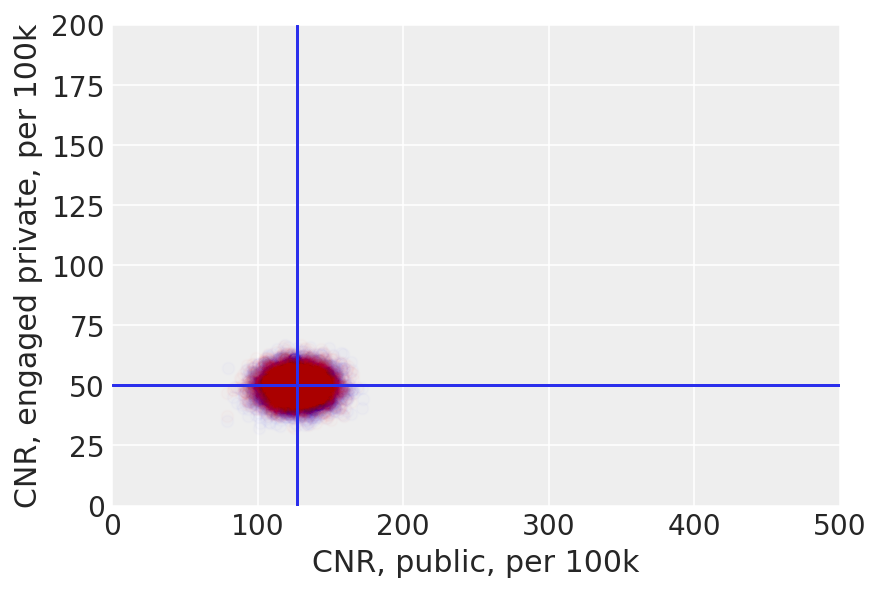

In [13]:
plt.scatter(post_re[0], post_re[1], color='b', alpha = 0.01)
plt.scatter(post[0], post[1], color='r', alpha = 0.01)

plt.axvline(x=obs[0] * 1e5, linestyle='-')
plt.axhline(y=obs[1] * 1e5, linestyle='-')

plt.ylim((0, 200))
plt.xlim((0, 500))

plt.xlabel('CNR, public, per 100k')
plt.ylabel('CNR, engaged private, per 100k')

Text(0, 0.5, 'Prevalence, untreated, per 100k')

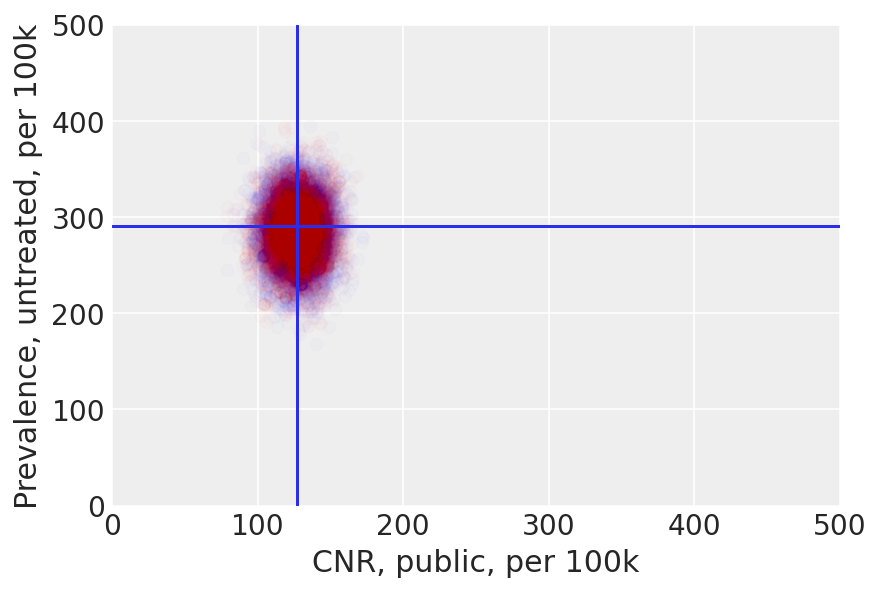

In [14]:
plt.scatter(post_re[0], post_re[2], color='b', alpha = 0.01)
plt.scatter(post[0], post[2], color='r', alpha = 0.01)

plt.axvline(x=obs[0] * 1e5, linestyle='-')
plt.axhline(y=obs[2] * 1e5, linestyle='-')

plt.ylim((0, 500))
plt.xlim((0, 500))

plt.xlabel('CNR, public, per 100k')
plt.ylabel('Prevalence, untreated, per 100k')

array([[<AxesSubplot:title={'center':'ppv_pri'}>,
        <AxesSubplot:title={'center':'ppv_pri'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'dur_succ_pri'}>,
        <AxesSubplot:title={'center':'dur_succ_pri'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'p_pridrug'}>,
        <AxesSubplot:title={'center':'p_pridrug'}, xlabel='Rank (all chains)'>]],
      dtype=object)

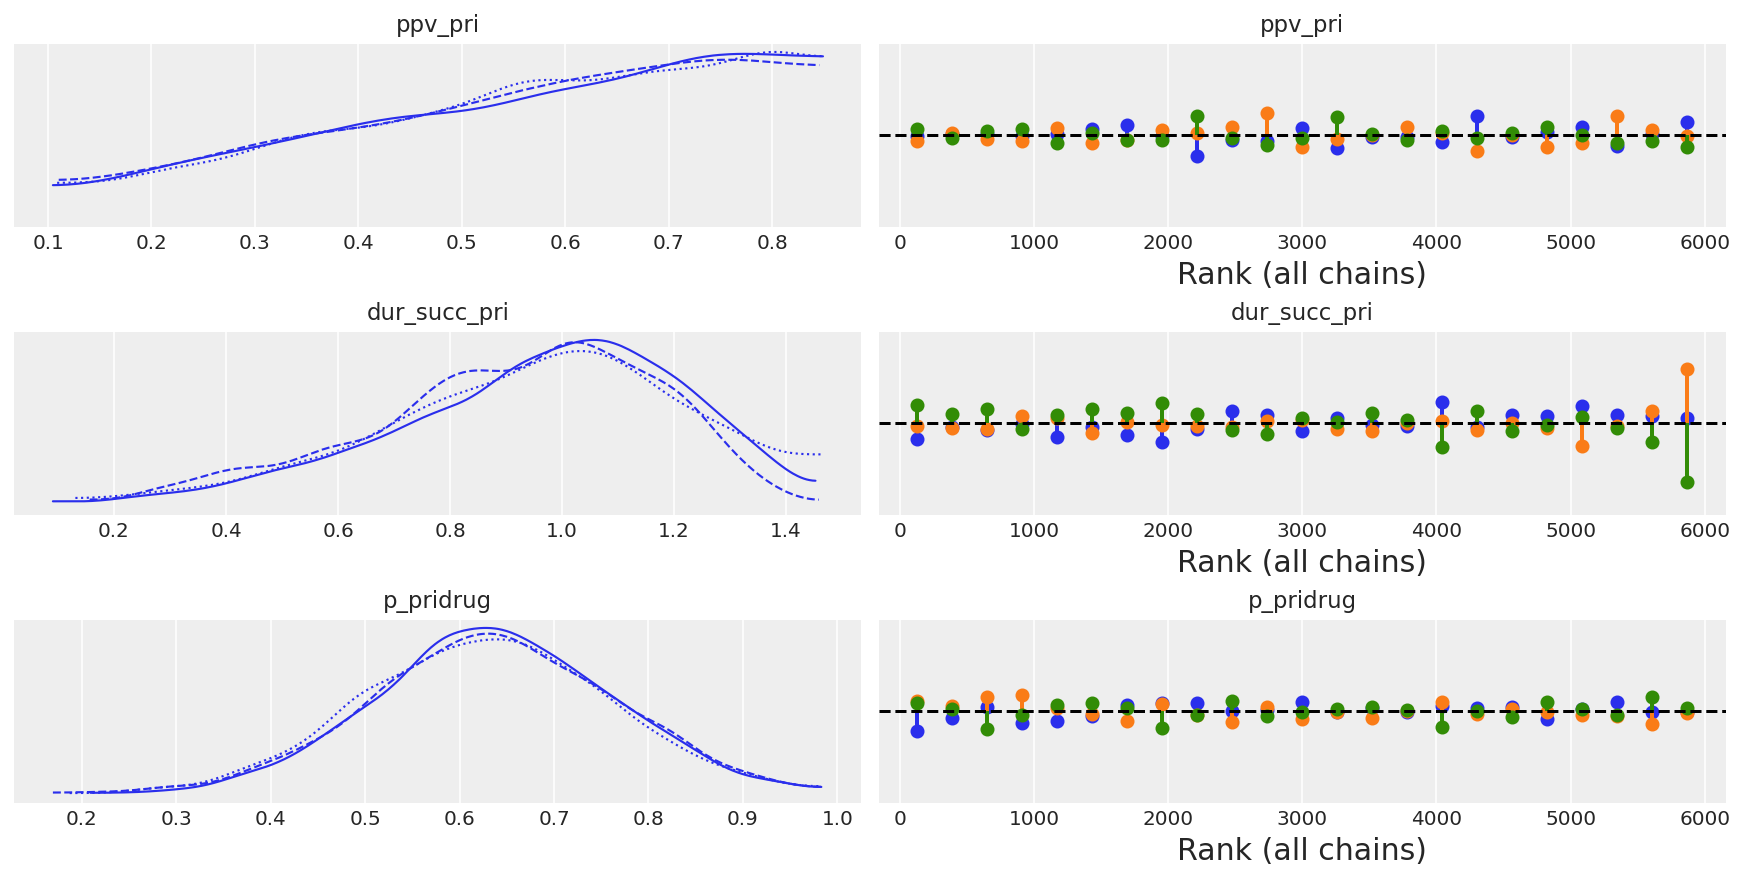

In [15]:
az.plot_trace(idata_fit, var_names=['ppv_pri', 'dur_succ_pri', 'p_pridrug'], kind="rank_vlines")

array([[<AxesSubplot:title={'center':'ppv_pri'}>,
        <AxesSubplot:title={'center':'ppv_pri'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'dur_succ_pri'}>,
        <AxesSubplot:title={'center':'dur_succ_pri'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'p_pridrug'}>,
        <AxesSubplot:title={'center':'p_pridrug'}, xlabel='Rank (all chains)'>]],
      dtype=object)

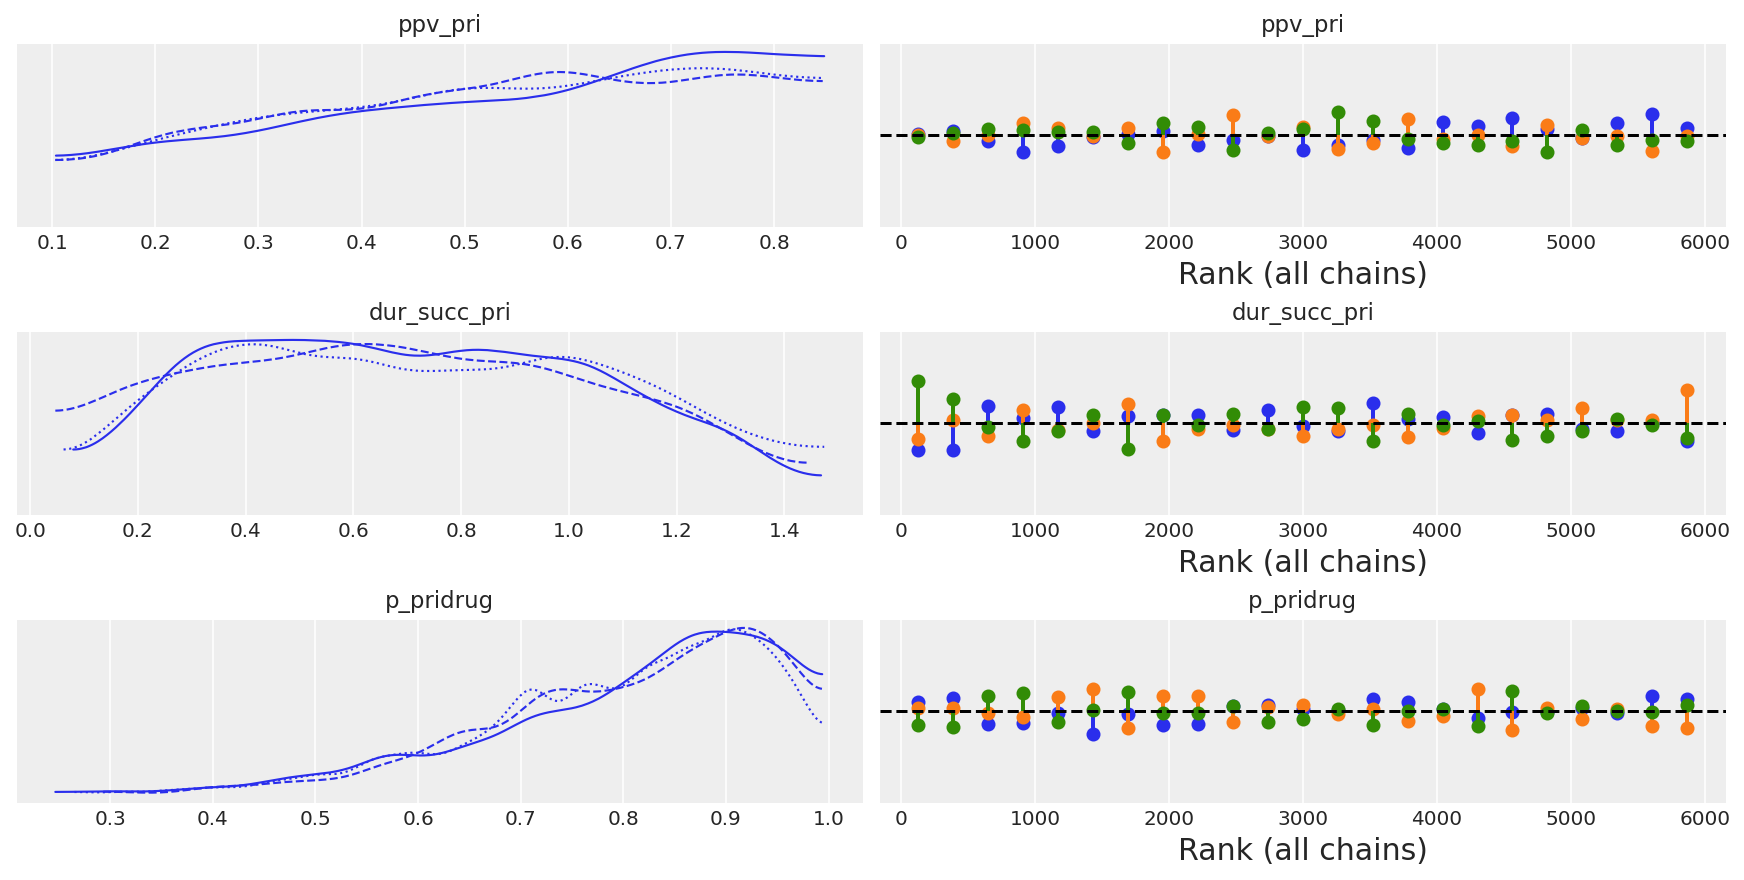

In [16]:
az.plot_trace(idata_fit_reduced, var_names=['ppv_pri', 'dur_succ_pri', 'p_pridrug'], kind="rank_vlines")

/opt/conda/envs/pymc-dev/lib/python3.10/site-packages/arviz/plots/pairplot.py:242: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  warnings.warn(


array([[<AxesSubplot:ylabel='p_det_pub'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='p_eng'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='p_pridrug'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='ppv_pri'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='dur_succ_pri'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='p_det_pub', ylabel='dur_succ_eng'>,
        <AxesSubplot:xlabel='p_eng'>, <AxesSubplot:xlabel='p_pridrug'>,
        <AxesSubplot:xlabel='ppv_pri'>,
        <AxesSubplot:xlabel='dur_succ_pri'>,
        <AxesSubplot:xlabel='dur_succ_eng'>]], dtype=object)

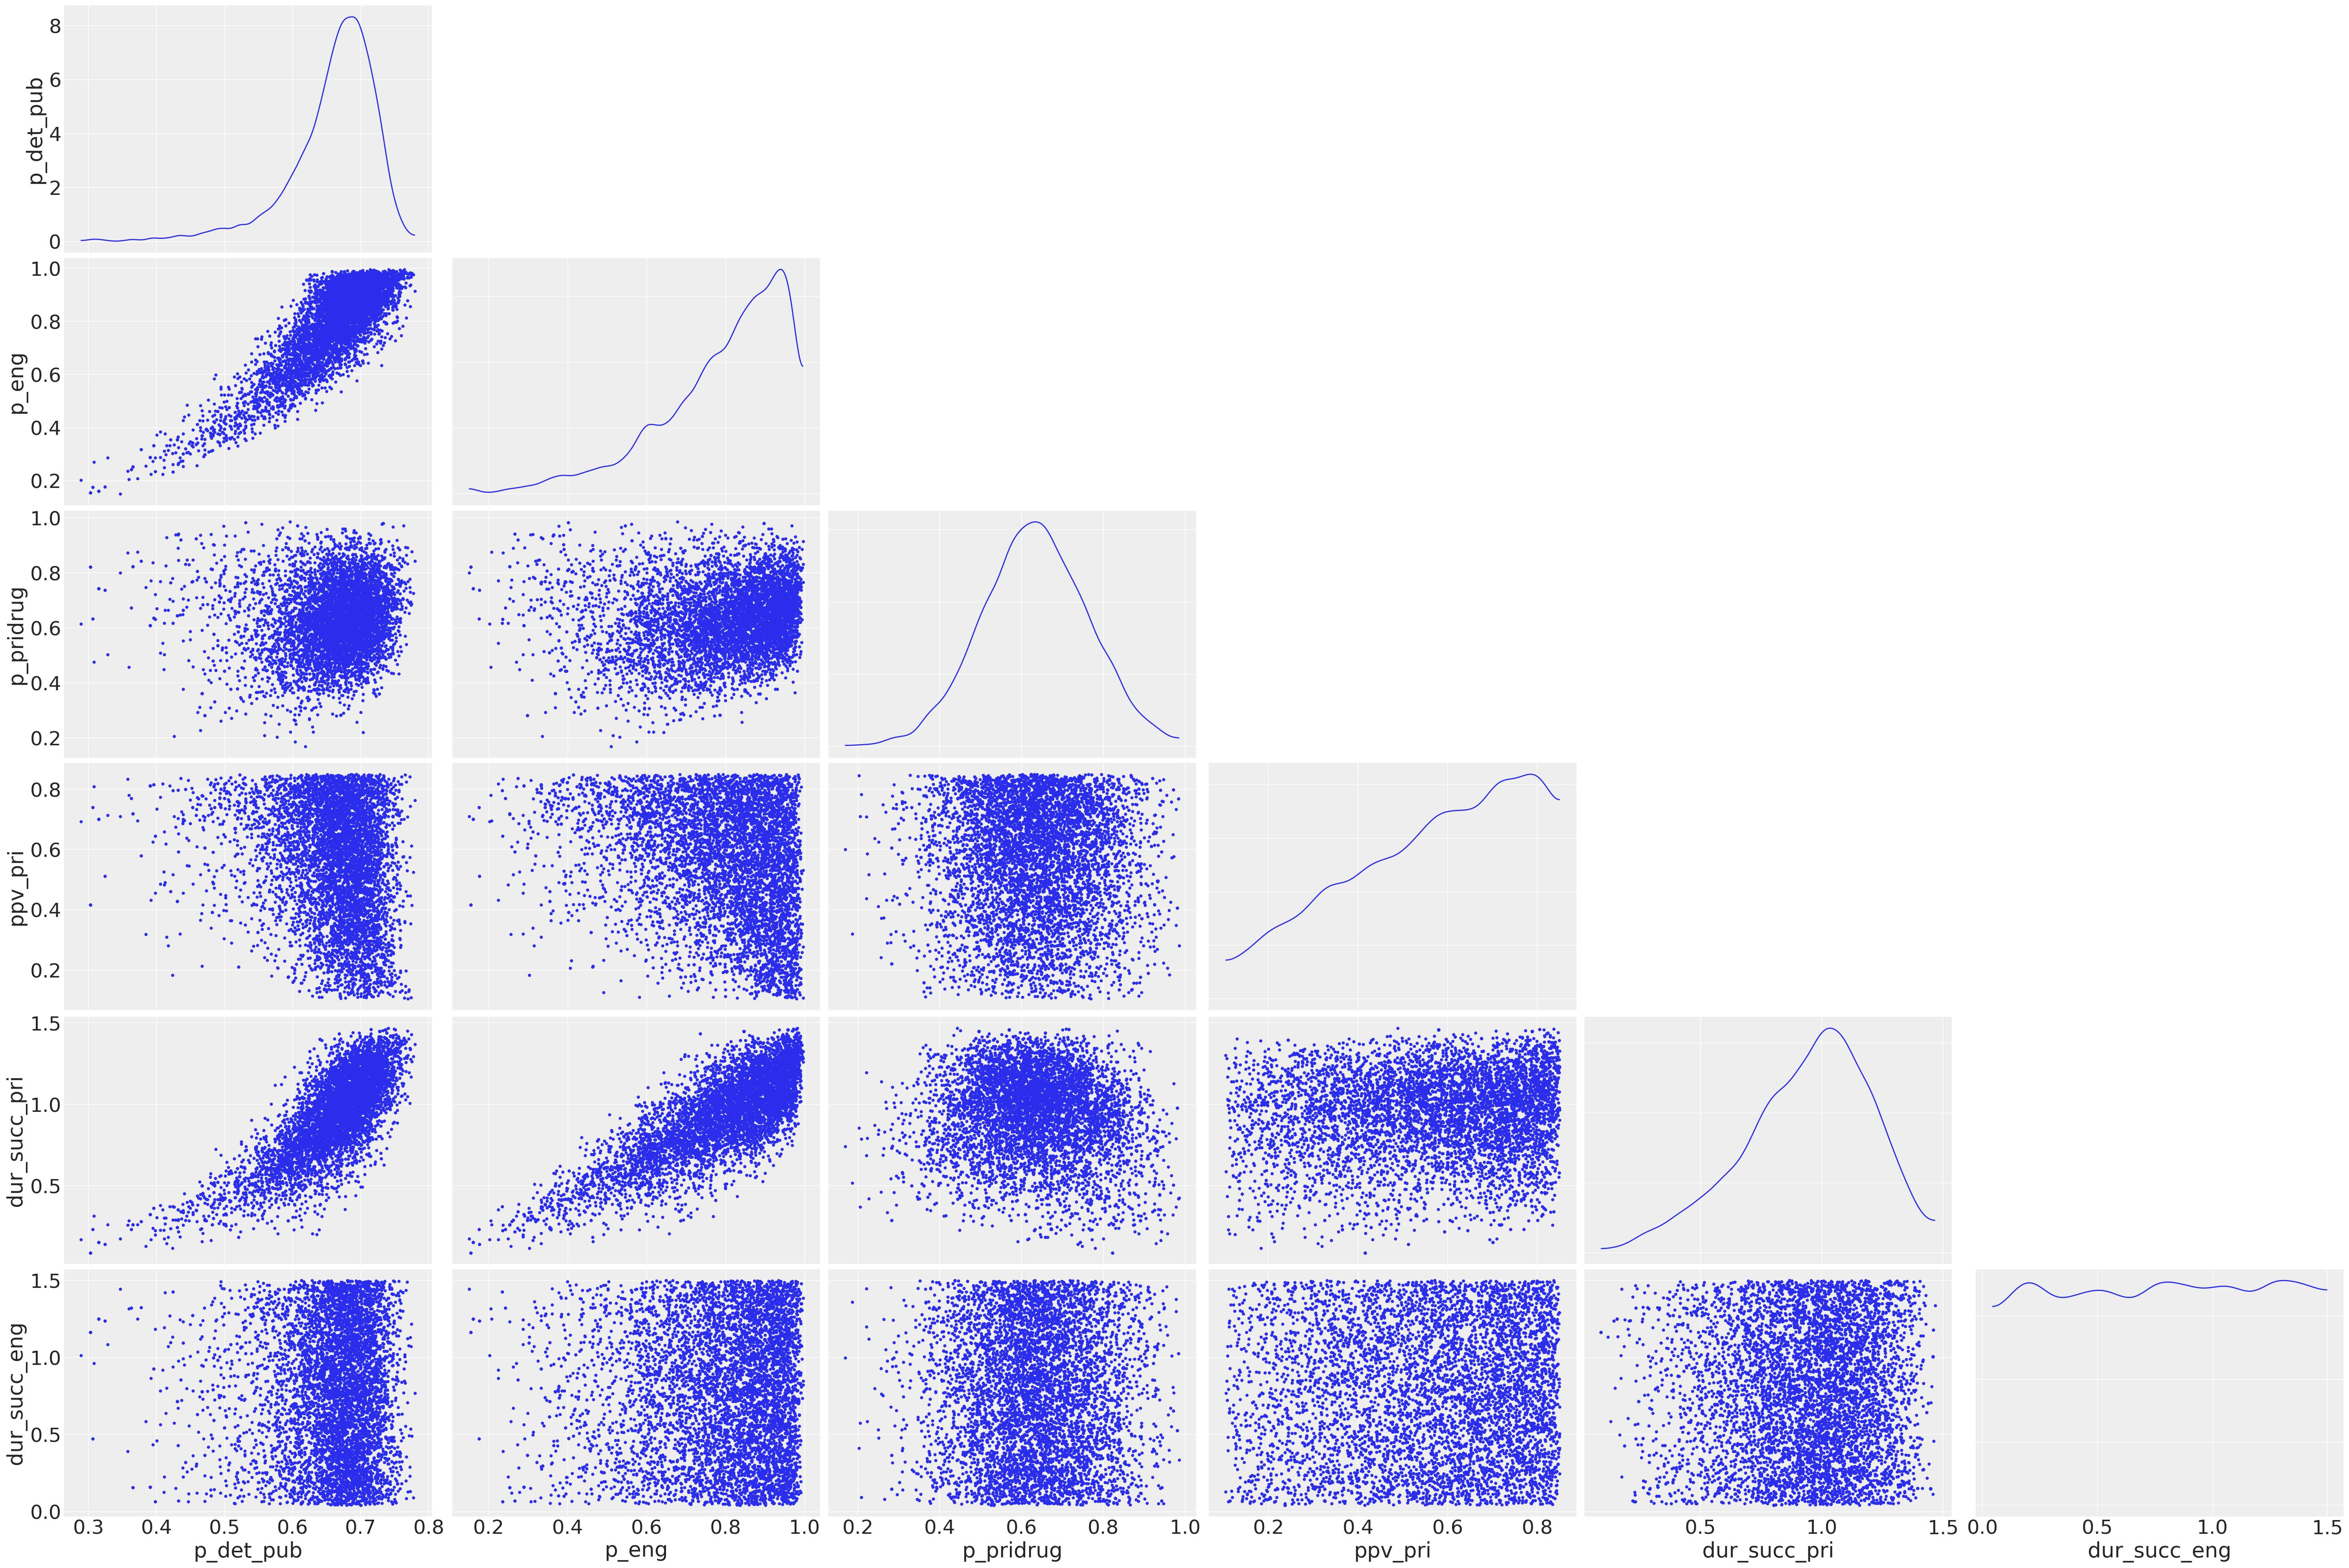

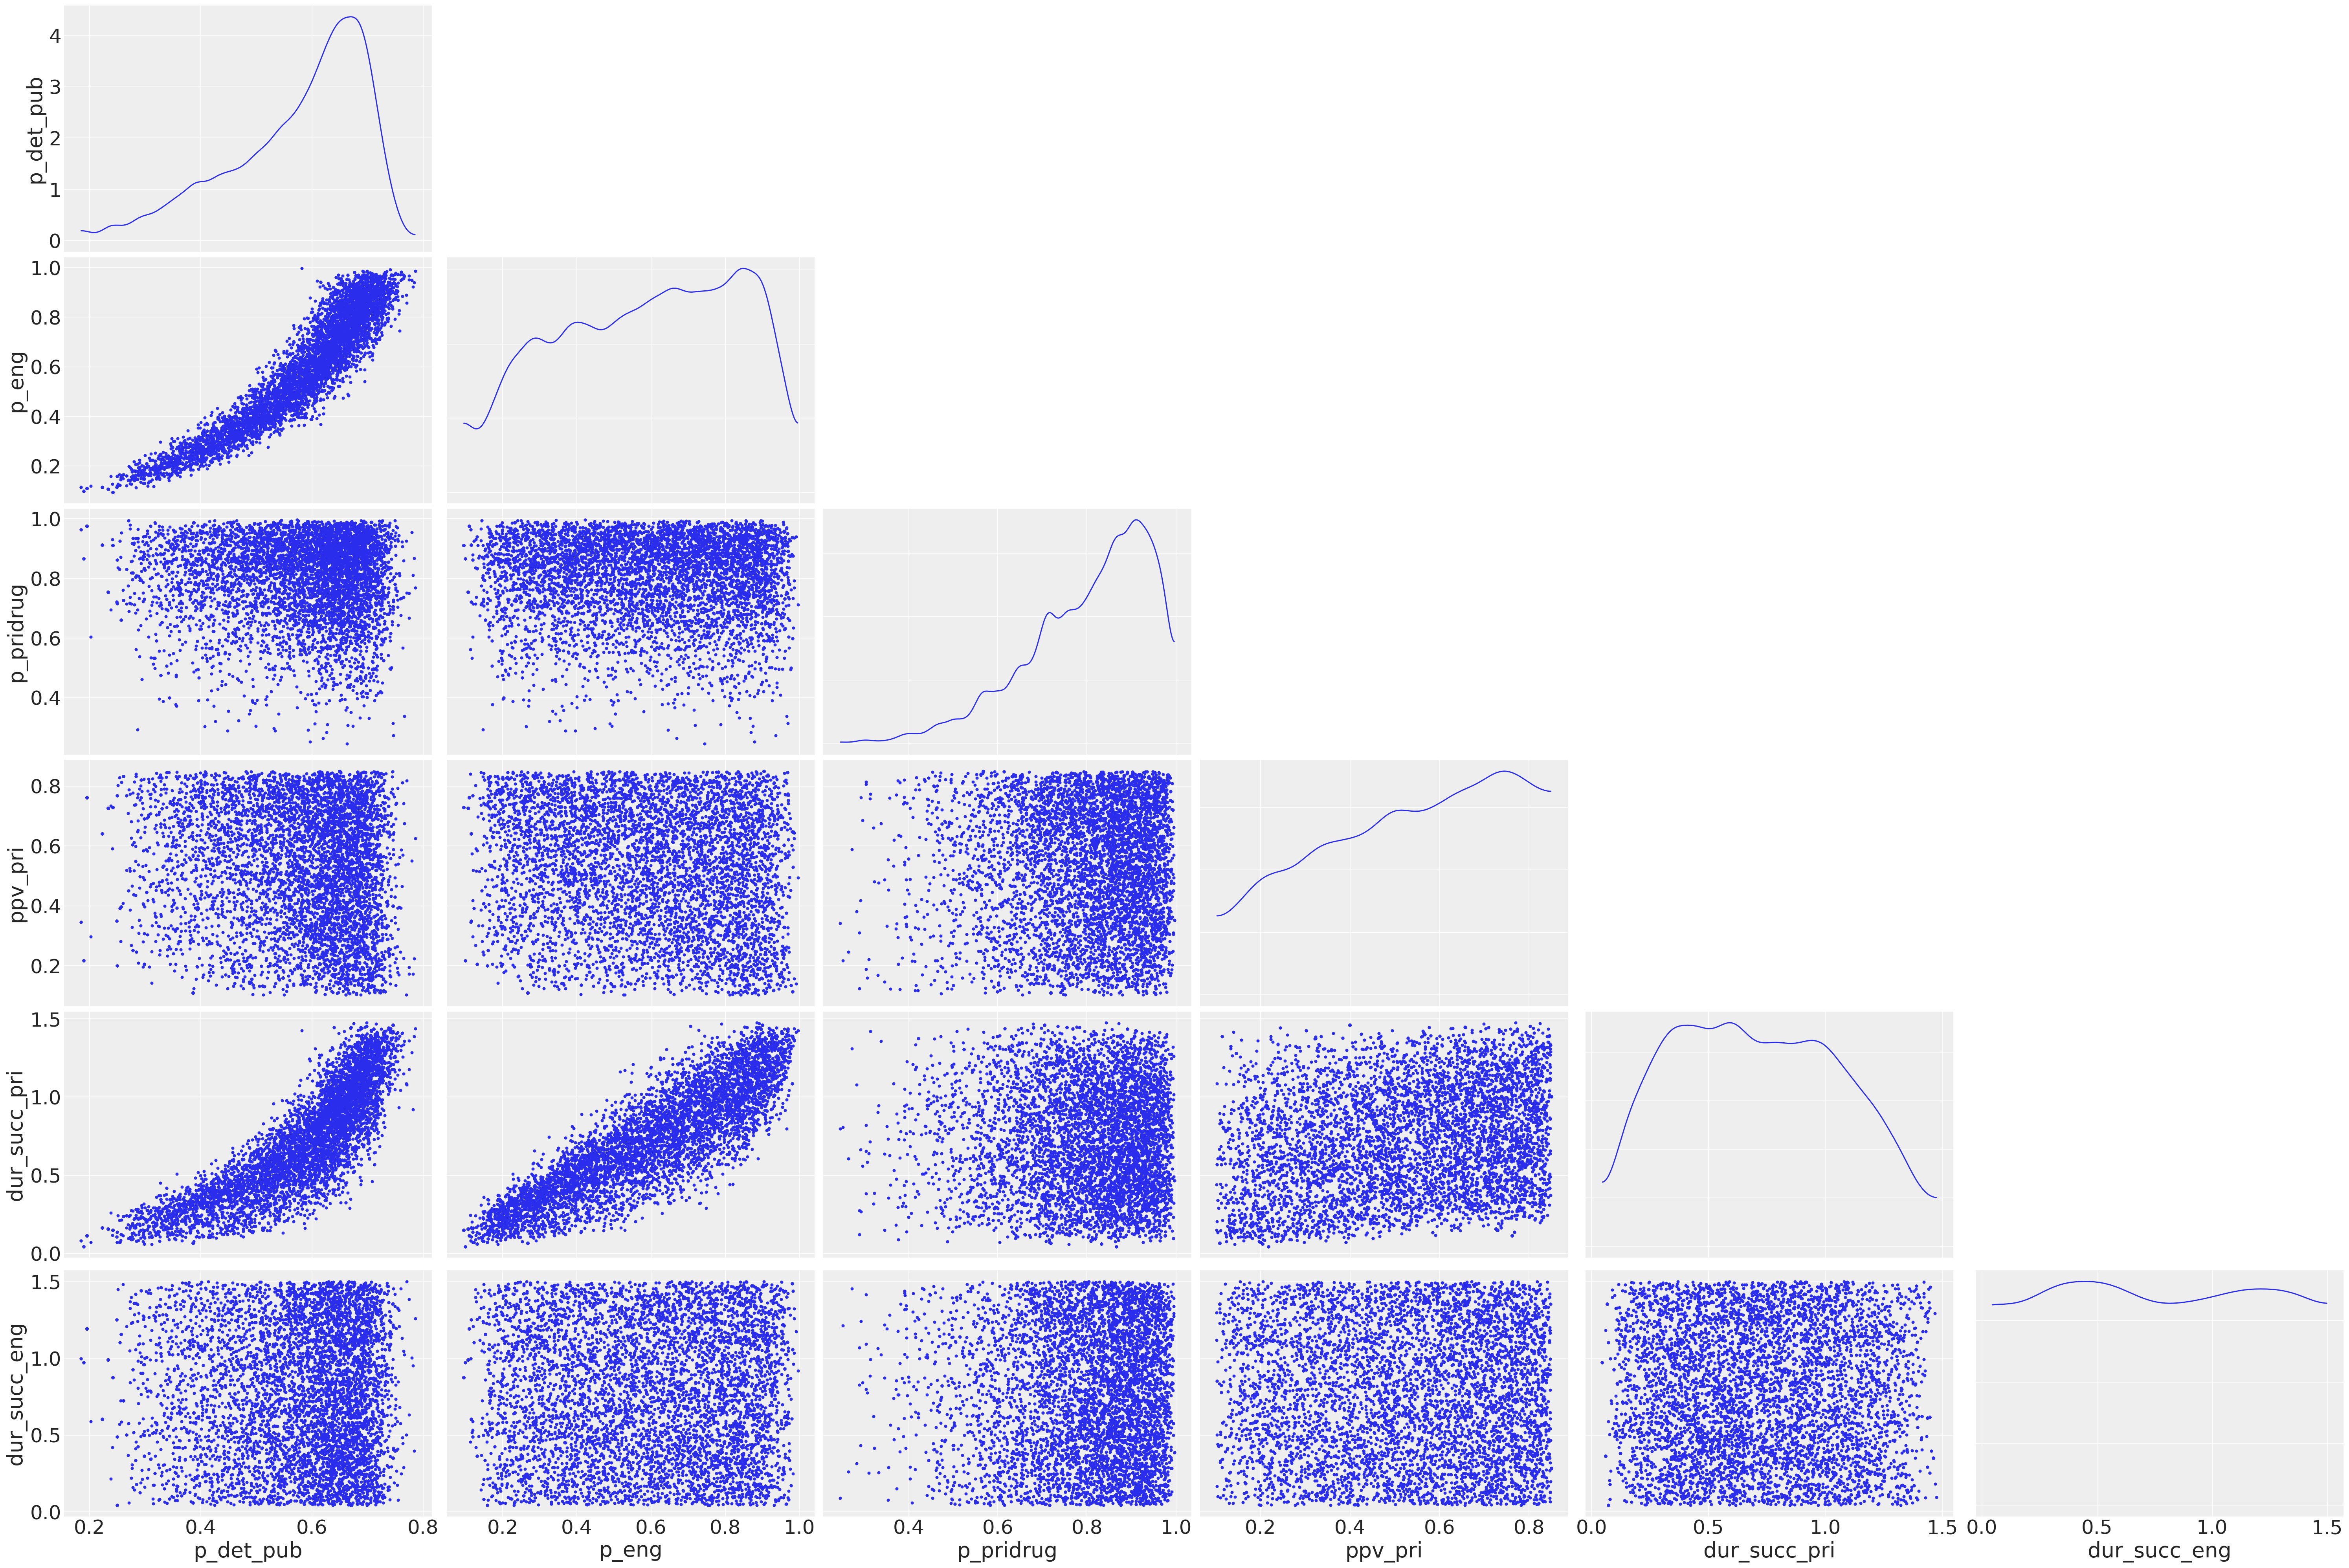

In [17]:
az.plot_pair(
    idata_fit,
    var_names=['p_det_pub', 'p_eng', 'p_pridrug', 'ppv_pri', 'dur_succ_pri', 'dur_succ_eng'],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
)

az.plot_pair(
    idata_fit_reduced,
    var_names=['p_det_pub', 'p_eng', 'p_pridrug', 'ppv_pri', 'dur_succ_pri', 'dur_succ_eng'],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
)

array([[<AxesSubplot:>, None],
       [<AxesSubplot:xlabel='p_det_pub', ylabel='p_eng'>, <AxesSubplot:>]],
      dtype=object)

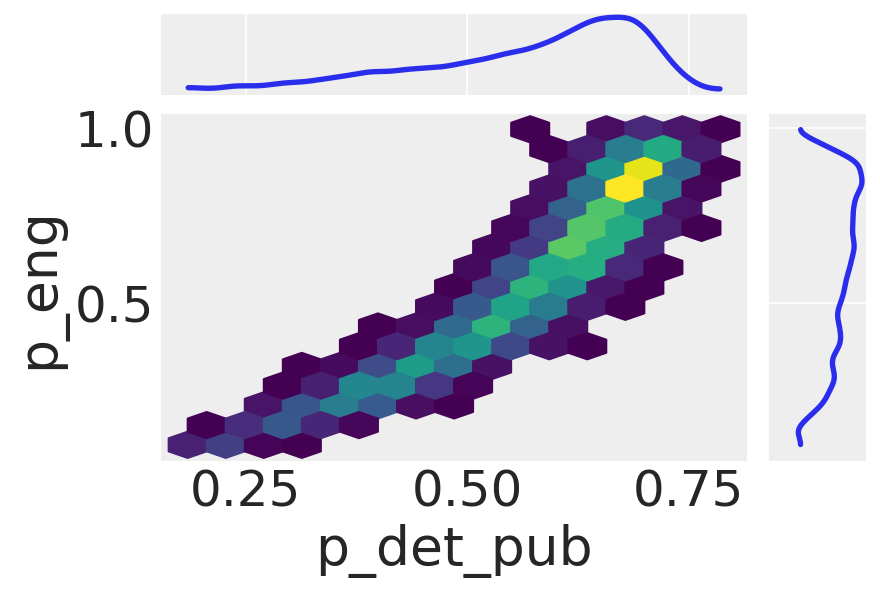

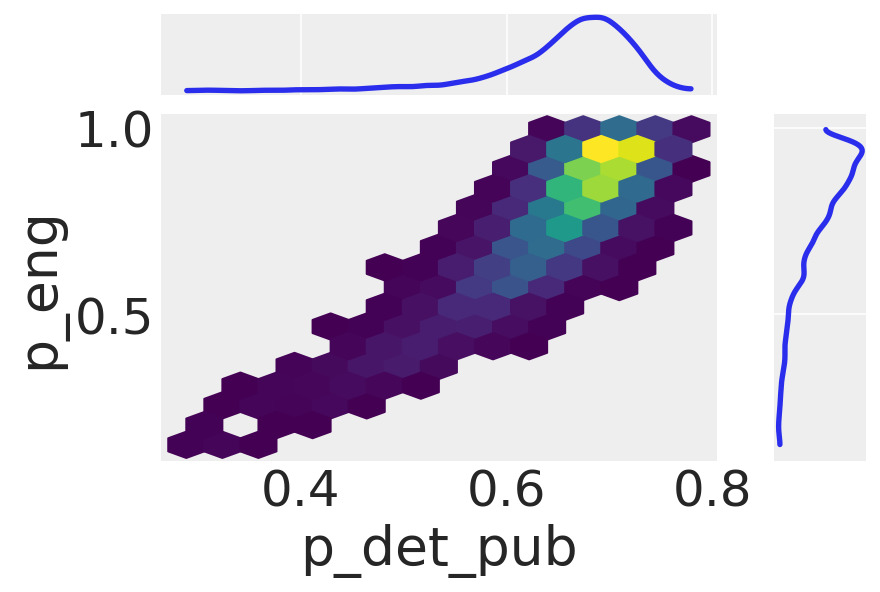

In [18]:
az.plot_pair(
    idata_fit_reduced,
    var_names=['p_det_pub', 'p_eng'],
    kind="hexbin",
    divergences=True,
    textsize=25,
    marginals=True,
)


az.plot_pair(
    idata_fit,
    var_names=['p_det_pub', 'p_eng'],
    kind="hexbin",
    divergences=True,
    textsize=25,
    marginals=True
)


array([[<AxesSubplot:ylabel='ppv_pri'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='dur_succ_pri'>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='ppv_pri', ylabel='p_pridrug'>,
        <AxesSubplot:xlabel='dur_succ_pri'>,
        <AxesSubplot:xlabel='p_pridrug'>]], dtype=object)

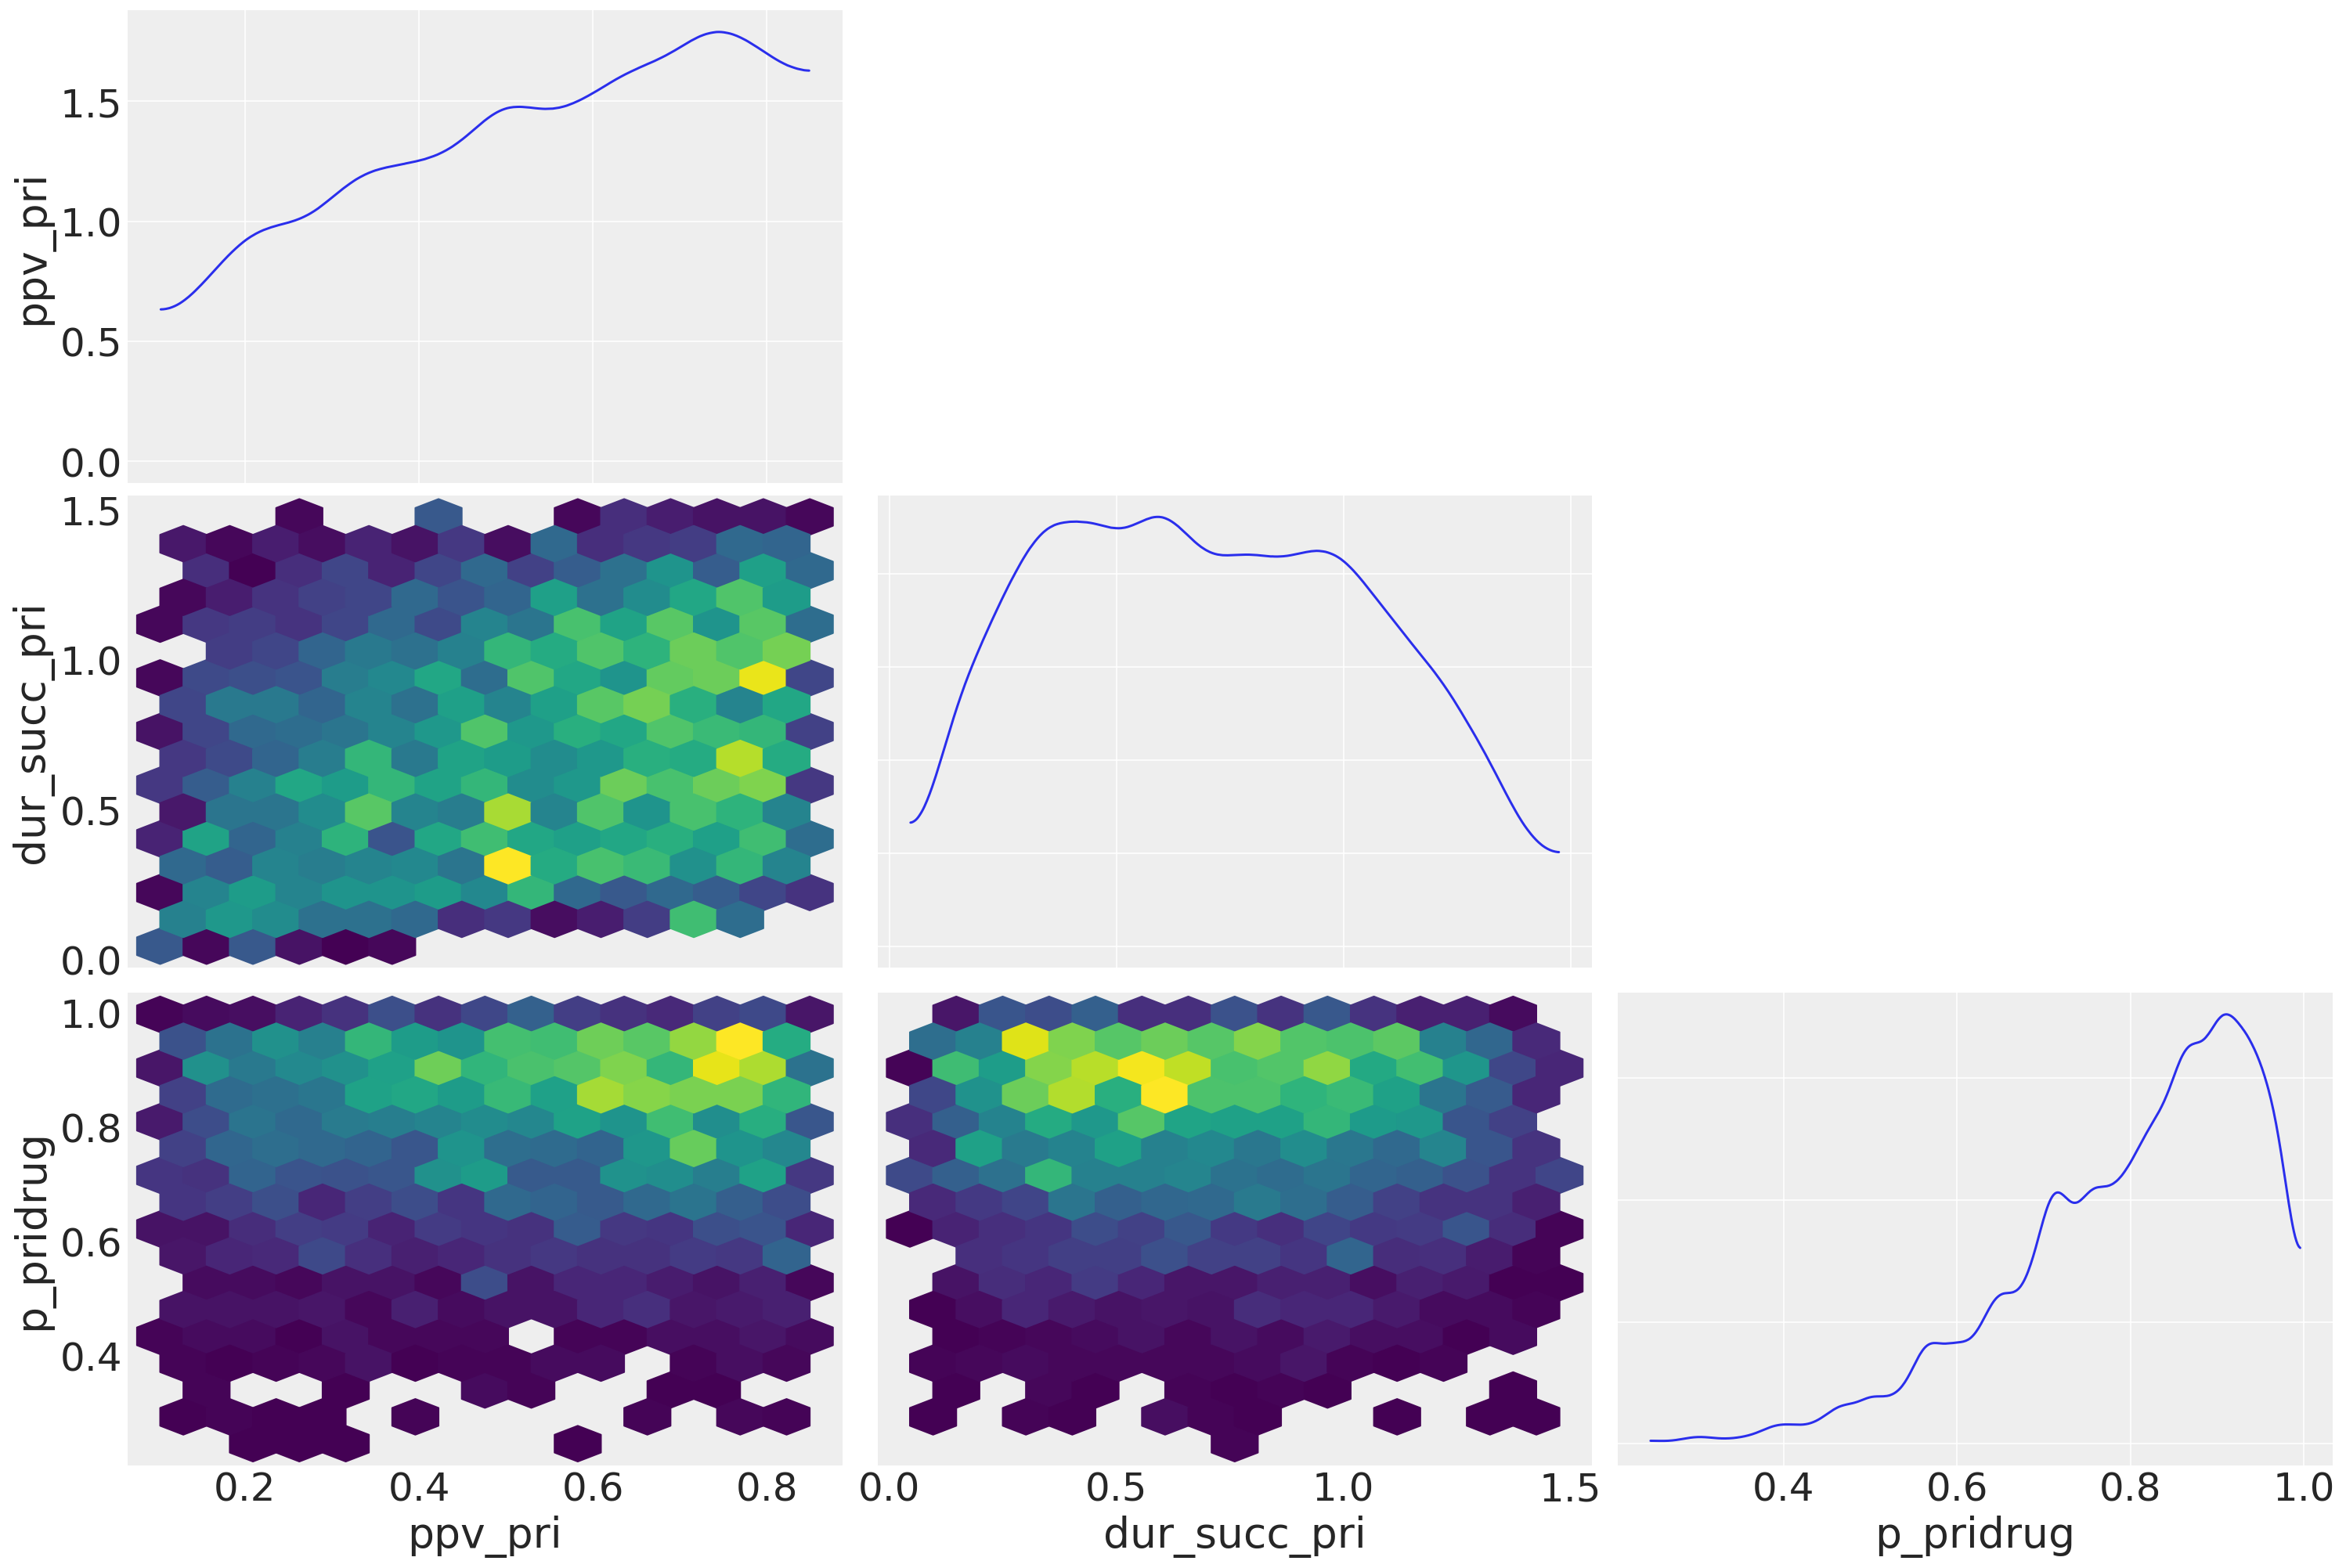

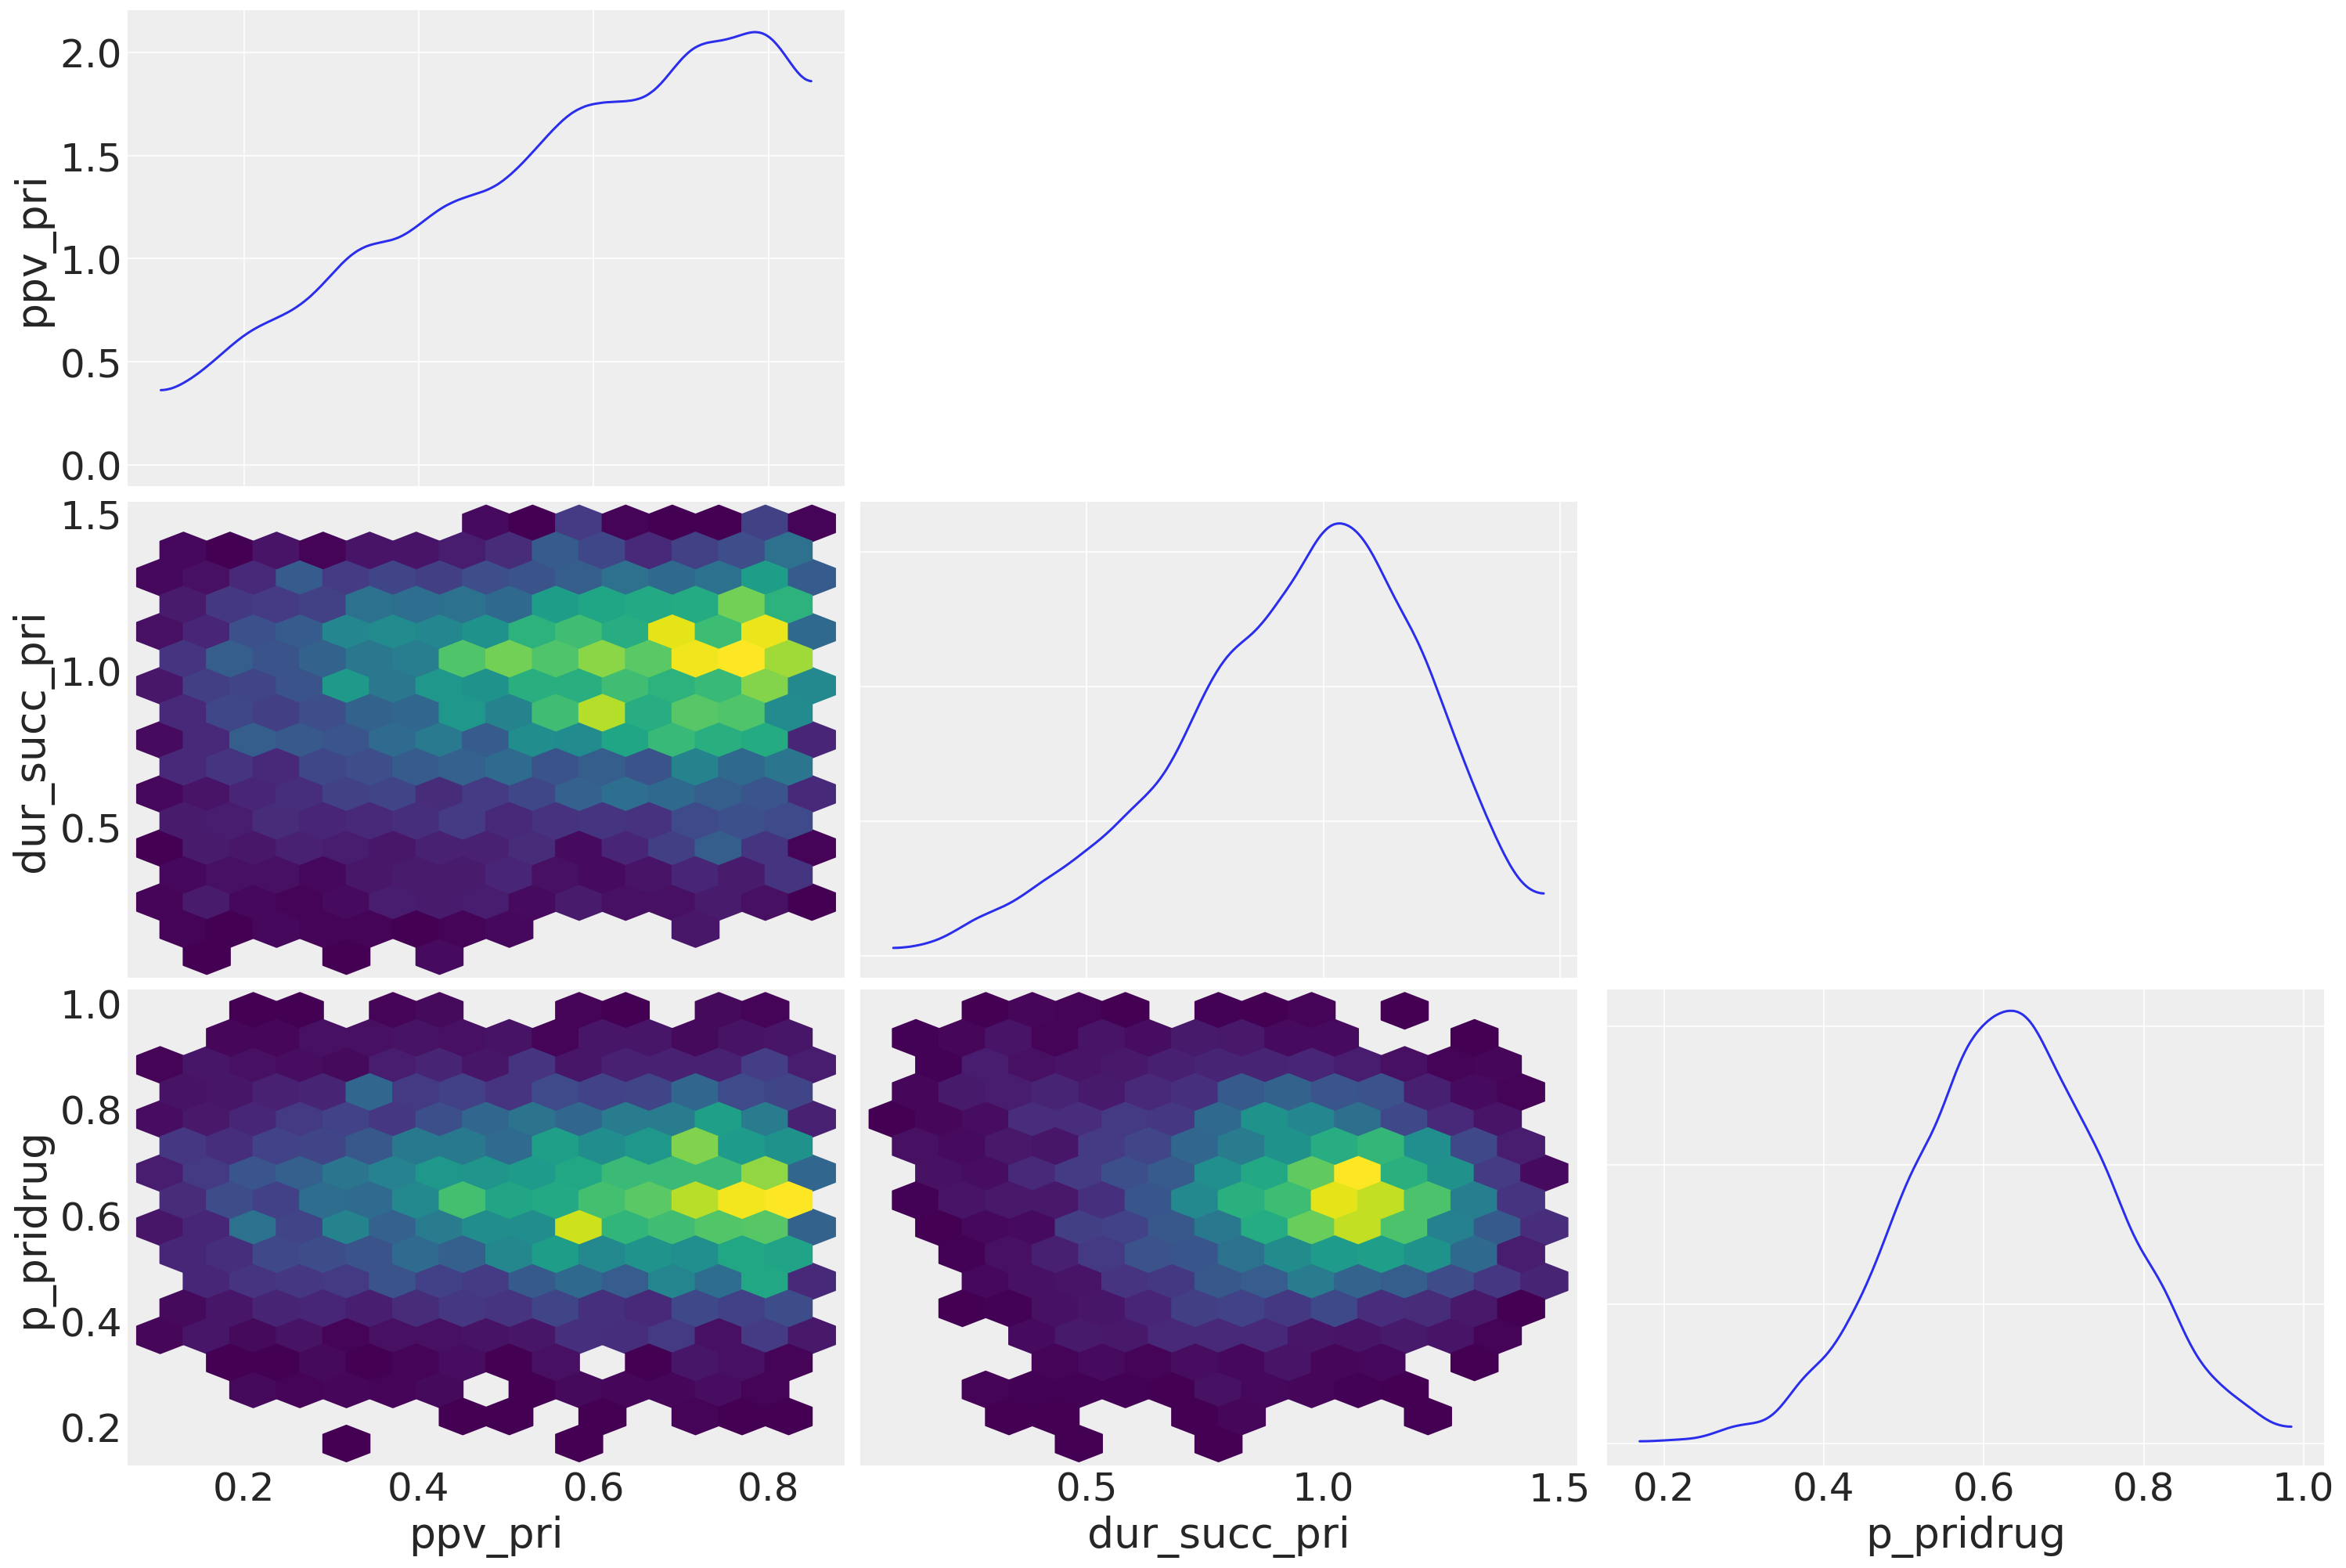

In [19]:

az.plot_pair(
    idata_fit_reduced,
    var_names=['ppv_pri', 'dur_succ_pri', 'p_pridrug'],
    kind="hexbin",
    divergences=True,
    textsize=25,
    marginals=True,
)


az.plot_pair(
    idata_fit,
    var_names=['ppv_pri', 'dur_succ_pri', 'p_pridrug'],
    kind="hexbin",
    divergences=True,
    textsize=25,
    marginals=True
)


In [20]:
def to_particles(po, m):
    variables = list(po.variables.keys())
    variables = [v for v in variables if v != 'samples']
    variables
    vs = {k: po[k].to_numpy() for k in variables}
    n_samples = len(vs[variables[0]])
    pts = [{k: v[i] for k, v in  vs.items()} for i in range(n_samples)]
    
    pts = list()
    
    for i in range(n_samples):
        pt = {k: v[i] for k, v in  vs.items()}
        pt = m.reform_parameters(
            ppv_pub = 0.85,
            ppv_eng = 0.85,
            TxI_pri = 0.8,
            dur_succ_pub = 0.5,
            **pt
        )
        
        ms = m.calc(pt)
        pt['CNR_Pub'] = ms['CNR'][0]
        pt['CNR_Eng'] = ms['CNR'][1]
        pt['PrevUt'] = ms['PrevUt']
        pt['OnPriCare'] = ms['OnPriCare']
        pt['OnPriDrug'] = ms['OnPriDrug']
        
        for i, sector in enumerate(['Pub', 'Eng', 'Pri']):
            pt[f'Dur_{sector}'] = ms['Duration'][i]
            pt[f'TxI_{sector}'] = ms['TxI'][i]
            
        pts.append(pt)
    
    return pts

In [21]:
po = idata_fit.posterior.stack(samples=("draw", "chain"))
po = to_particles(po, m)
po = pd.DataFrame(po)
po.to_csv('out/pymc_fit/post_tbps_ds.csv')

In [22]:
po = idata_fit_reduced.posterior.stack(samples=("draw", "chain"))
po = to_particles(po, m)
po = pd.DataFrame(po)
po.to_csv('out/pymc_fit/post_tbps.csv')

In [23]:
post_txi = dict()

for txi in [0.5, 0.8, 0.9]:
    with pm.Model() as model_lv:
        inc = pm.Uniform('inc', 0, 0.02)
        r_die_ut = pm.Uniform("r_die_ut", 0.14, 0.18)
        rr_die_asym = pm.Uniform("rr_die_asym", 0, 1)
        r_sc = pm.Uniform("r_sc", 0.1, 0.3)
        r_onset = pm.Uniform('r_onset', 0.5, 5)

        ppv_pub = 0.85 #pm.Constant('ppv_pub', 0.85)
        ppv_eng = 0.85 # pm.Constant('ppv_eng', 0.85)
        ppv_pri = pm.Uniform('ppv_pri', 0.1, 0.85)

        TxI_pri = txi #pm.Uniform('TxI_pri', 0.5, 1)
        dur_succ_pub = 0.5 # pm.Constant('dur_succ_pub', 0.5)
        dur_succ_eng = pm.Uniform('dur_succ_eng', 1/ 24, 1.5)
        dur_succ_pri = pm.Uniform('dur_succ_pri', 1/ 24, 1.5)

        p_det_pub = pm.Uniform('p_det_pub', 0, 1)
        p_eng = pm.Uniform('p_eng', 0, 1)
        p_pridrug = pm.Beta('p_pridrug', 6, 1.5) #pm.Uniform('p_pridrug', 0.5, 0.9)

        sim = pm.Simulator("sim", simulate, 
                           params=(inc, 
                                   r_die_ut, rr_die_asym, r_sc, r_onset, ppv_pub, ppv_eng, ppv_pri, TxI_pri, 
                                   dur_succ_pub, dur_succ_eng, dur_succ_pri, p_det_pub, p_eng, p_pridrug), 
                           epsilon=eps, observed=obs)

        pfit = pm.sample_smc(chains=4, cores=5, draws=2000)
        psim = pm.sample_posterior_predictive(idata_fit, var_names=["sim"])
    post_txi[txi] = {
        'pars': pfit,
        'sims': psim
    }

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Initializing SMC sampler...
Sampling 4 chains in 4 jobs


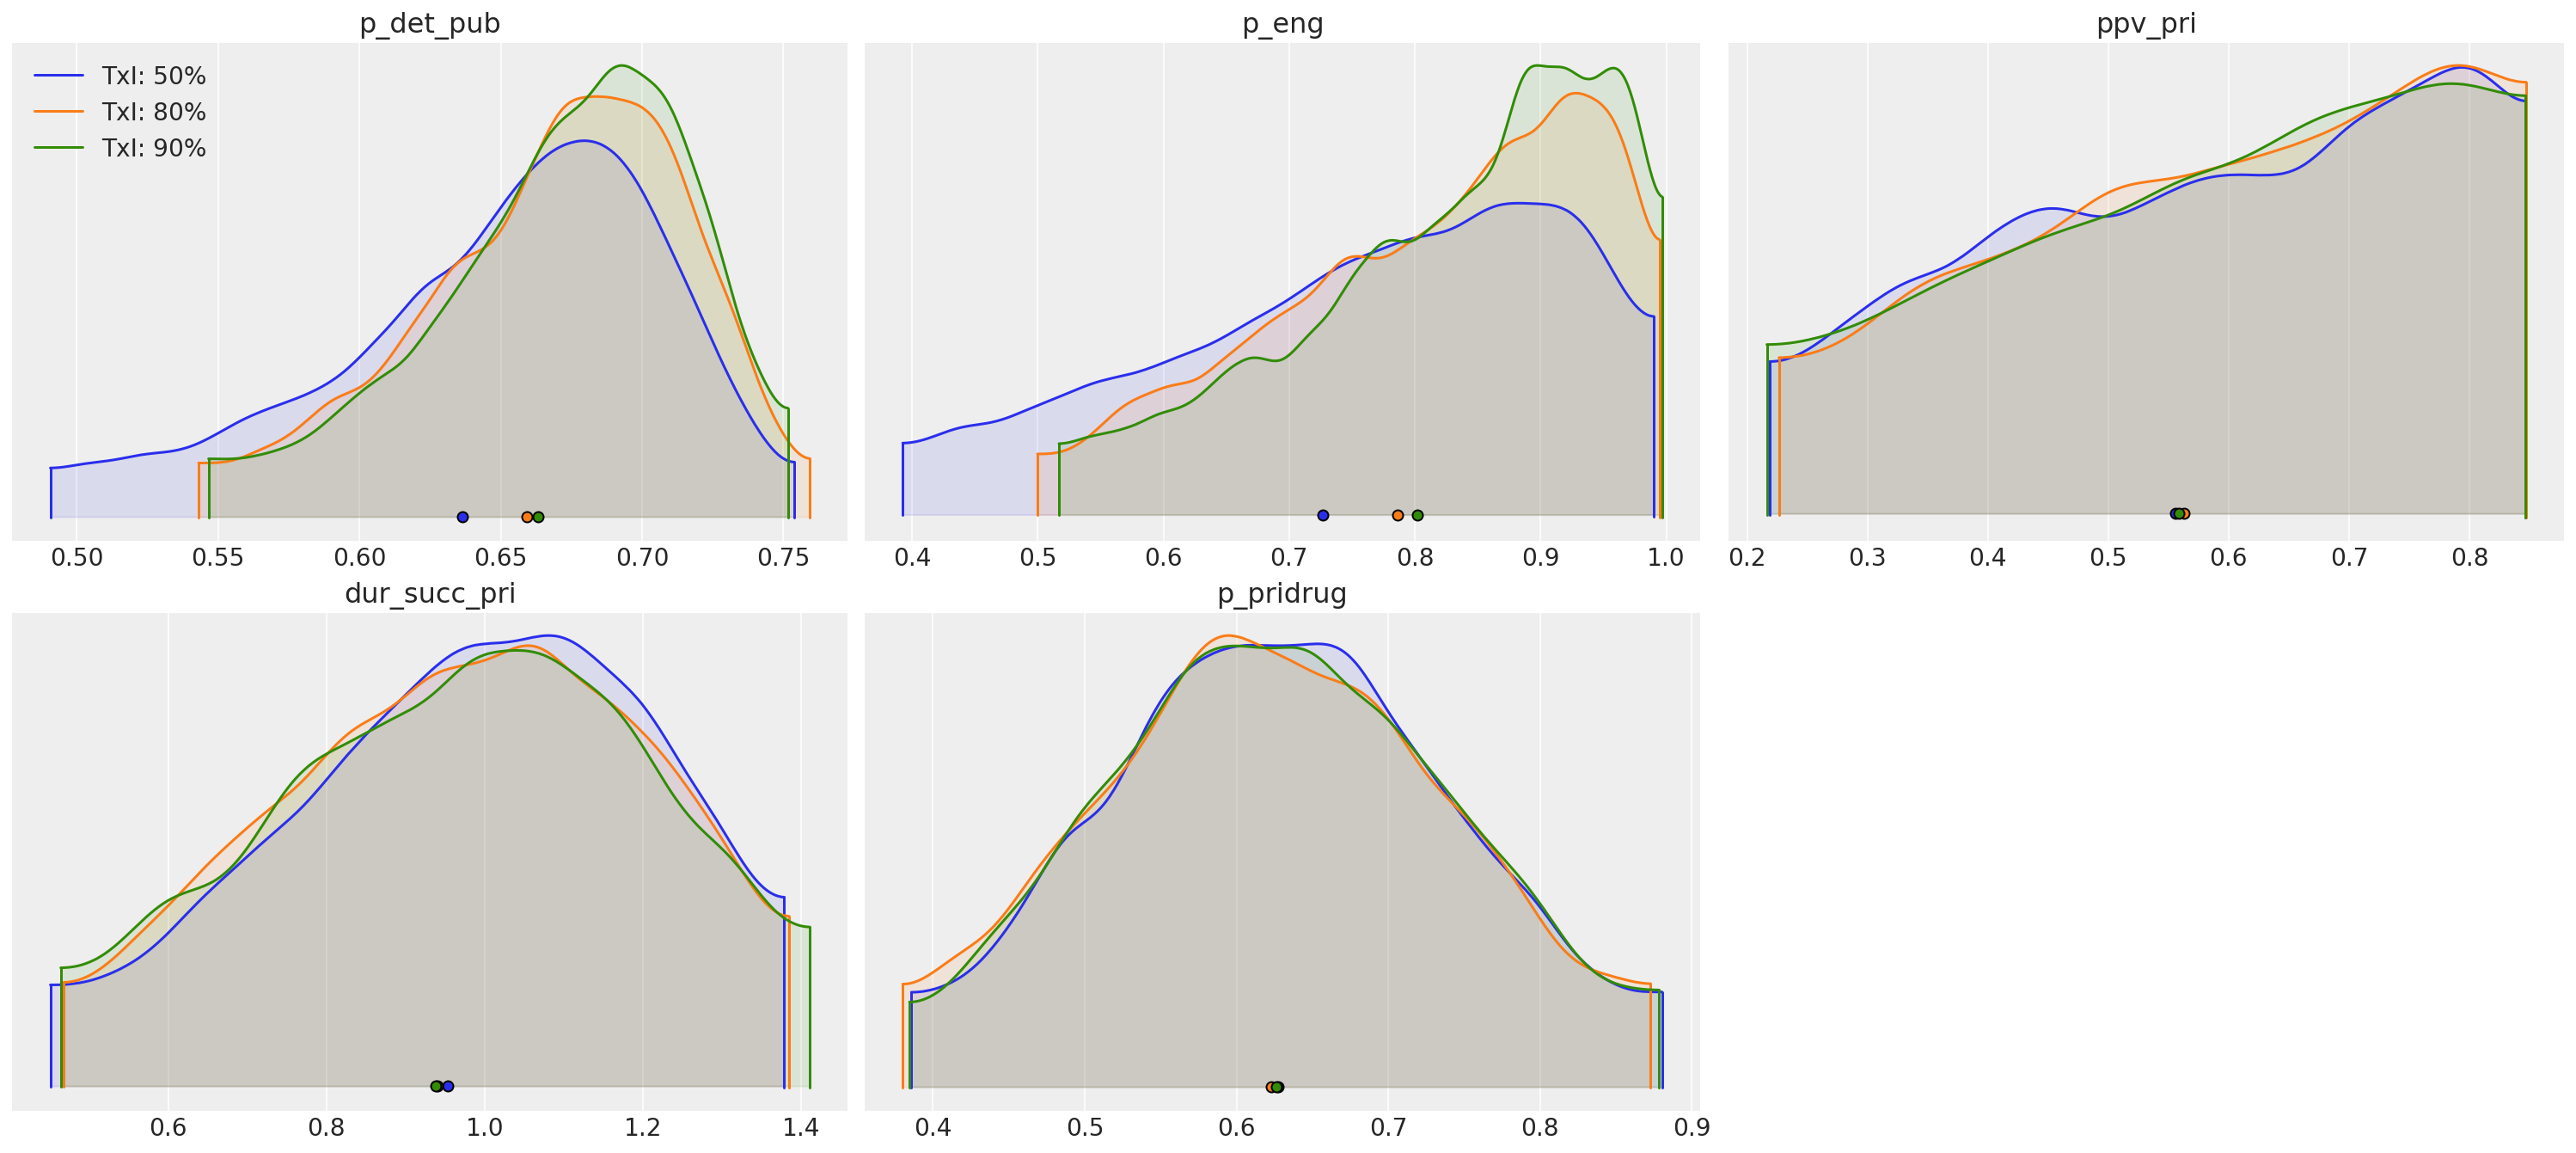

In [35]:

az.plot_density(
    [post_txi[0.5]['pars'], post_txi[0.8]['pars'], post_txi[0.9]['pars']],
    data_labels=["TxI: 50%", "TxI: 80%", "TxI: 90%"],
    var_names=['p_det_pub', 'p_eng', 'ppv_pri', 'dur_succ_pri', 'p_pridrug'],
    shade=0.1,
)

data_labels=["Centered", "Non Centered"],



In [27]:
post_txi.keys()

dict_keys([0.5, 0.8, 0.9])

In [31]:
ppost.posterior_predictive.to_dataframe().to_csv('out/pymc_fit/PredPrevDS.csv')
idata_fit.posterior.to_dataframe().to_csv('out/pymc_fit/ParsPrevDS.csv')
ppost_reduced.posterior_predictive.to_dataframe().to_csv('out/pymc_fit/PredPrev.csv')
idata_fit_reduced.posterior.to_dataframe().to_csv('out/pymc_fit/ParsPrev.csv')

In [33]:
for k, v in post_txi.items():
    v['pars'].posterior.to_dataframe().to_csv(f'out/pymc_fit/Pars_{k}.csv')
    v['sims'].posterior_predictive.to_dataframe().to_csv(f'out/pymc_fit/Pred_{k}.csv')
